# Tutorial 4 - Termodinámica Avanzada

## Ajuste de parámetros de interacción para mezclas.

Funciones de optimización disponibles:
- [Quadratic mixing rule](#qmr)
- [NRTL](#nrtl)
- [Wilson](#wilson)
- [UNIQUAC](#uniquac)

---
Llamemos $\underline{\xi}$ a los parámetros de optimización de una mezcla. Para optimizarlos, es necesario proporcionar datos de equilibrios de fases experimentales. Esto puede incluir datos VLE, ​​LLE y VLLE. La función objetivo utilizada para cada tipo de equilibrio se muestra a continuación:


### Datos de equilibrios vapor-líquido


$$ OF_{VLE}(\underline{\xi}) = w_y \sum_{j=1}^{Np} \left[ \sum_{i=1}^c (y_{i,j}^{cal} - y_{i,j}^{exp})^2 \right] + w_P \sum_{j=1}^{Np} \left[ \frac{P_{j}^{cal} - P_{j}^ {exp}}{P_{j}^{exp}} \right]^2$$

Donde, $Np$ es el número de puntos de datos experimentales, $y_i$ es la fracción molar de vapor del componente $i$ y $P$ es la presión de burbuja. Los superíndices $cal$ y $exp$ se refieren a los valores calculados y experimentales, respectivamente. Finalmente, $w_y$ es el peso del error de composición del vapor y $w_P$ es el peso del error de presión de burbuja.


### Datos de equilibrio líquido-líquido
$$ OF_{LLE}(\underline{\xi}) = w_x \sum_{j=1}^{Np} \sum_{i=1}^c  \left[x_{i,j} - x_{i,j}^{exp}\right]^2 +  w_w \sum_{j=1}^{Np} \sum_{i=1}^c \left[ w_{i,j} - w_{i,j}^{exp} \right]^2 $$

Donde, $Np$ es el número de puntos de datos experimentales, $x_i$ y $w_i$ son la fracción molar del componente $i$ en las fases líquidas. Los superíndices $cal$ y $exp$ se refieren a los valores calculados y experimentales, respectivamente. Finalmente, $w_x$ y $w_w$ son los pesos para el error de composición del líquido 1 ($x$) y del líquido 2 ($w$).


### Datos de equilibrio vapor-líquido-líquido
$$ OF_{VLLE}(\underline{\xi}) = w_x \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[x_{i,j}^{cal} - x_{i,j}^{exp}\right]^2 + w_w \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[w_{i,j}^{cal} - w_{i,j}^{exp}\right]^2 +  w_y \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[y_{i,j}^{cal} - y_{i,j}^{exp}\right]^2 + w_P \sum_{j=1}^{Np}  \left[ \frac{P_{j}^{cal}}{P_{j}^{exp}} - 1\right]^2 $$

Donde, $Np$ es el número de puntos de datos experimentales, $y_i$, $x_i$ y $w_i$ son la fracción molar del componente $i$ en las fases de vapor y líquido, respectivamente. Los superíndices $cal$ y $exp$ se refieren a los valores calculados y experimentales, respectivamente. Finalmente, $w_x$ y $w_w$ son los pesos para el error de composición del líquido 1 ($x$) y del líquido 2 ($w$), $w_y$ es el peso para el error de composición del vapor y $w_P$ es el peso para tres. Error de presión de equilibrio de fase.

Si hay datos para más de un tipo de equilibrio, los errores se pueden sumar en consecuencia. Entonces la función objetivo queda como:

$$ OF(\underline{\xi}) =OF_{ELV}(\underline{\xi}) + OF_{ELL}(\underline{\xi}) + OF_{ELLV}(\underline{\xi}) $$

---
Este tutorial tiene el propósito de mostrar ejemplos de cómo ajustar parámetros de interacción para mezclas binarias utilizando datos de equilibrios experimentales.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from phasepy import component, mixture, prsveos

Ahora que las funciones están disponibles es necesario crear la mezcla.

In [2]:
water = component(name = 'Water', Tc = 647.13, Pc = 220.55, Zc = 0.229, Vc = 55.948, w = 0.344861,
                ksv = [ 0.87292043, -0.06844994],
                Ant =  [  11.72091059, 3852.20302815,  -44.10441047],
                cii = [ 1.16776082e-25, -4.76738739e-23,  1.79640647e-20],
                GC = {'H2O':1},
                ri=0.92, qi=1.4)

ethanol = component(name = 'Ethanol', Tc = 514.0, Pc = 61.37, Zc = 0.241, Vc = 168.0, w = 0.643558,
                ksv = [1.27092923, 0.0440421 ],
                Ant = [  12.26474221, 3851.89284329,  -36.99114863],
                cii = [ 2.35206942e-24, -1.32498074e-21,  2.31193555e-19],
                GC = {'CH3':1, 'CH2':1, 'OH(P)':1},
                ri=2.1055, qi=1.972)

mix = ethanol + water

Ahora se leen los datos de equilibrios experimentales y se crea una tupla. Incluye la composición del líquido experimental, la composición del vapor, la temperatura y presión de equilibrio. Esto se hace con ```datavle = (Xexp, Yexp, Texp, Pexp)```

Si la mezcla presenta otros tipos de equilibrios, puede suministrar estos datos experimentales a los parámetros ``datalle`` o ``datavlle``.

- ``datalle``: (Xexp, Wexp, Texp, Pexp)
- ``datavlle``: (Xexp, Wexp, Yexp, Texp, Pexp)

Puede especificar los pesos para cada función objetivo a través de los siguientes parámetros:

- ``weights_vle``: lista o tipo array, pesos para la función objetivo de VLE.
        -weights_vle[0] = peso para el error de composición Y, el valor predeterminado es 1.
        -weights_vle[1] = peso para error de presión de burbuja, valor predeterminado 1.
- ``weights_lle``: tipo lista o array_like, pesos para la función objetivo LLE.
        -weights_lle[0] = peso para el error de composición de X (líquido 1), el valor predeterminado es 1.
        -weights_lle[1] = error de composición de peso para W (líquido 2), por defecto 1.
- ``weights_vlle``: tipo lista o array_like, pesos para la función objetivo VLLE.
        -weights_vlle[0] = error de composición de peso para X (líquido 1), valor predeterminado 1.
        -weights_vlle[1] = error de composición de peso para W (líquido 2), valor predeterminado 1.
        -weights_vlle[2] = peso para el error de composición de Y (vapor), valor predeterminado 1.
        -weights_vlle[3] = peso para el error de presión de equilibrio, el valor predeterminado es 1.

Además, puede configurar opciones para la función ``minimizar`` de SciPy usando el parámetro ``minimize_options``.

In [19]:
#Datos de equilibrios de vapor líquido obtenidos de Rieder, Robert M. y A. Ralph Thompson (1949).
# «Vapor-Liquid Equilibria Measured by a GillespieStill - Ethyl Alcohol - Water System». 
#Ind. Eng. Chem. 41.12, 2905-2908.

#Saturation Pressure in bar
Pexp = np.array([1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013])

#Saturation temeprature in Kelvin
Texp = np.array([372.45, 370.05, 369.15, 369.15, 368.75, 367.95, 366.95, 366.65,
       366.05, 363.65, 363.65, 362.55, 361.55, 361.75, 360.35, 358.55,
       357.65, 357.15, 356.55, 356.15, 355.45, 355.15, 354.55, 354.65,
       354.35, 354.05, 353.65, 353.35, 353.15, 352.65, 351.95, 351.65,
       351.55, 351.45])

#Liquid fraction mole array
Xexp = np.array([[0.0028, 0.0118, 0.0137, 0.0144, 0.0176, 0.0222, 0.0246, 0.0302,
        0.0331, 0.0519, 0.053 , 0.0625, 0.0673, 0.0715, 0.0871, 0.126 ,
        0.143 , 0.172 , 0.206 , 0.21  , 0.255 , 0.284 , 0.321 , 0.324 ,
        0.345 , 0.405 , 0.43  , 0.449 , 0.506 , 0.545 , 0.663 , 0.735 ,
        0.804 , 0.917 ],
       [0.9972, 0.9882, 0.9863, 0.9856, 0.9824, 0.9778, 0.9754, 0.9698,
        0.9669, 0.9481, 0.947 , 0.9375, 0.9327, 0.9285, 0.9129, 0.874 ,
        0.857 , 0.828 , 0.794 , 0.79  , 0.745 , 0.716 , 0.679 , 0.676 ,
        0.655 , 0.595 , 0.57  , 0.551 , 0.494 , 0.455 , 0.337 , 0.265 ,
        0.196 , 0.083 ]])
#Vapor fraction mole array
Yexp = np.array([[0.032, 0.113, 0.157, 0.135, 0.156, 0.186, 0.212, 0.231, 0.248,
        0.318, 0.314, 0.339, 0.37 , 0.362, 0.406, 0.468, 0.487, 0.505,
        0.53 , 0.527, 0.552, 0.567, 0.586, 0.586, 0.591, 0.614, 0.626,
        0.633, 0.661, 0.673, 0.733, 0.776, 0.815, 0.906],
       [0.968, 0.887, 0.843, 0.865, 0.844, 0.814, 0.788, 0.769, 0.752,
        0.682, 0.686, 0.661, 0.63 , 0.638, 0.594, 0.532, 0.513, 0.495,
        0.47 , 0.473, 0.448, 0.433, 0.414, 0.414, 0.409, 0.386, 0.374,
        0.367, 0.339, 0.327, 0.267, 0.224, 0.185, 0.094]])

datavle = (Xexp, Yexp, Texp, Pexp)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


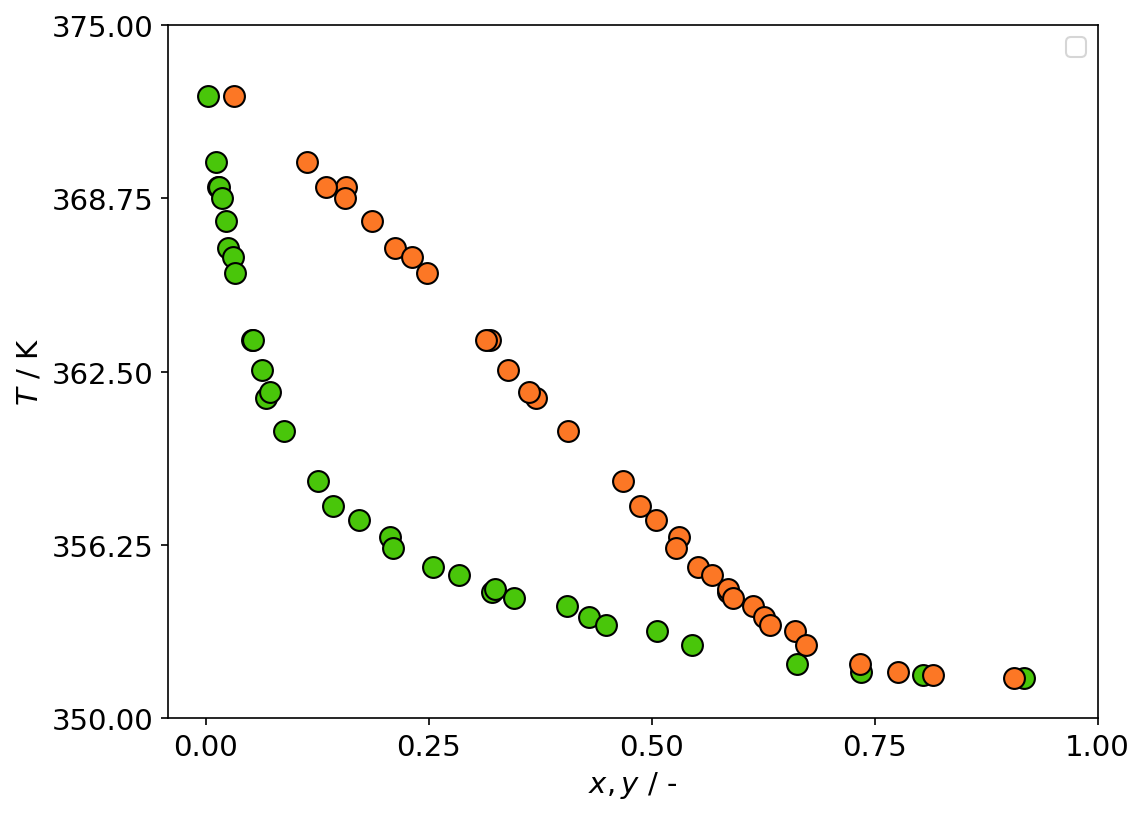

In [4]:
font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (8, 6), dpi = 150)
ax.scatter(Xexp[0], Texp, color = '#49C60A', marker = 'o', edgecolors='black', s=100)
ax.scatter(Yexp[0], Texp, color = '#FC7725', marker = 'o', edgecolors='black', s=100)

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x , y$ / -')
ax.xaxis.set_ticks(np.linspace(0, 1, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(350, 375, 5))

plt.show()

<a id='nrtl'></a>

## Ajuste de los parámetros de interacción NRTL

El modelo NRTL calcula el exceso de energía de Gibbs de la siguiente manera:

$$ g^e = \sum_{i=1}^c x_i \frac{\sum_{j=1}^c \tau_{ji}G_{ji}x_j}{\sum_{l=1}^c G_ {li}x_l}$$

Dónde,
$$ \tau_{ji} = \frac{A_{ji}}{T}, \quad G_{ji} = \exp{(-\alpha_{ji}\tau_{ji})}, \quad
\alpha_{ji} = \alpha_{ij} $$

Aquí $A_{ij}$ y $\alpha_{ij}$ son la energía de interacción y el factor aleatorio entre los componentes $i$ y $j$. Estos deben optimizarse a partir de datos experimentales.

A medida que se ajusta una matriz, se utilizan algoritmos de optimización multidimensional, la función ```fit_nrtl``` maneja esta optimización con varias opciones disponibles. Si se utiliza un valor fijo del factor aleatorio, la estimación inicial tiene la siguiente forma:

``nrtl0 = np.array([A12, A21])``

Si es necesario optimizar el factor aleatorio, se puede incluir configurando alpha_fixed en False; en este caso, la suposición inicial tiene la siguiente forma:

``nrtl0 = np.array([A12, A21, alfa])``

Los parámetros dependientes de la temperatura se pueden ajustar configurando la opción Tdep = True en ```fit_nrtl```, cuando se usa esta opción los parámetros se calculan como:

$$
A12 = A12_0 + A12_1 T \\
A21 = A21_0 + A21_1T
$$

La estimación inicial pasada a la función de ajuste tiene la siguiente forma:

``nrtl0 = np.array([A12_0, A21_0, A12_1, A21_1, alfa])``

o, si se utiliza alfa fijo.

``nrtl0 = np.array([A12_0, A21_0, A12_1, A21_1])``

**Nota:** puedes incluir las energías NRTL y factores aleatorios usando el método ``mix.NRTL``.

In [5]:
from phasepy.fit import fit_nrtl
mixnrtl = mix.copy()

#Valores iniciales A12, A21
nrtl0 = np.array([-80.,  650.])

# Rutina de optimización
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True)
# Valores optimos
#[-84.77530335, 648.78439102]

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0010806138452618098
        x: [-8.478e+01  6.488e+02]
      nit: 2
      jac: [ 5.719e-06 -3.409e-06]
 hess_inv: [[ 3.722e+05  9.475e+04]
            [ 9.475e+04  2.412e+04]]
     nfev: 33
     njev: 11

In [6]:
# Valores iniciales A12, A21
nrtl0 = np.array([-80.,  650.,  0.2])

# Rutina de optimización
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = False)
#optimized values for A12, A21, alpha
# [-5.53112687e+01,  6.72701992e+02,  3.19740734e-01]

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00019020559199284942
        x: [-5.531e+01  6.727e+02  3.197e-01]
      nit: 30
      jac: [-6.901e-08  9.498e-08 -5.024e-06]
 hess_inv: [[ 6.583e+05  6.053e+05  1.886e+03]
            [ 6.053e+05  5.566e+05  1.734e+03]
            [ 1.886e+03  1.734e+03  7.800e+00]]
     nfev: 124
     njev: 31

De forma predeterminada, la correlación virial de Tsonopoulos se calcula para la fase de vapor; si se desea, se puede utilizar el gas ideal o la correlación de Abbott.

In [7]:
# Valores iniciales A12, A21
nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True, virialmodel = 'Abbott')
#optimized values for A12, A21
#  [-8.482e+01  6.488e+02]

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0010802916180487176
        x: [-8.482e+01  6.488e+02]
      nit: 2
      jac: [ 5.744e-06 -3.383e-06]
 hess_inv: [[ 3.705e+05  9.591e+04]
            [ 9.591e+04  2.483e+04]]
     nfev: 33
     njev: 11

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


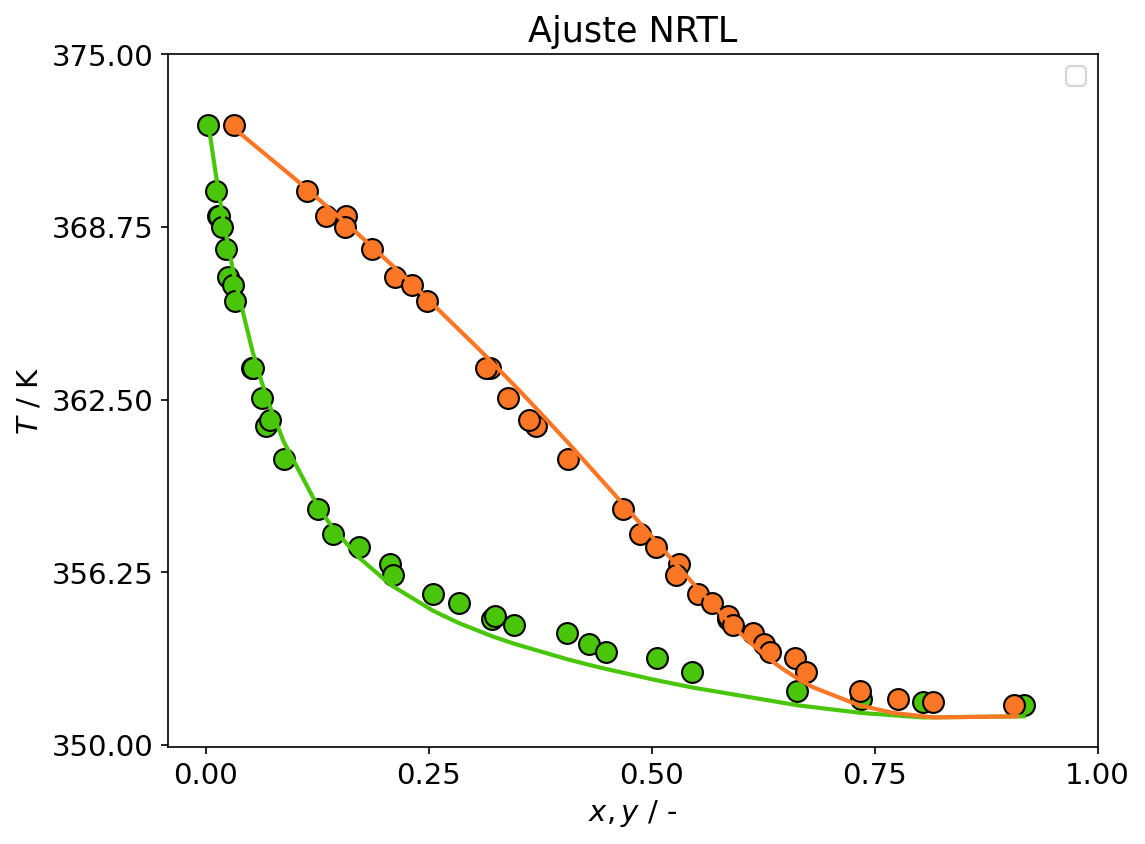

In [8]:
from phasepy import virialgamma
from phasepy.equilibrium import bubbleTy

Ynrtl = np.zeros_like(Yexp)
Tnrtl = np.zeros_like(Pexp)

alpha = np.array([[0.0, 3.19740734e-01],
                  [3.19740734e-01, 0.0]])
Aij0 = np.array([[0.0, -5.53112687e+01],
              [6.72701992e+02, 0.0]])

mix.NRTL(alpha, Aij0)

virialnrtl = virialgamma(mixnrtl, actmodel = 'nrtl')

n = len(Pexp)

for i in range(n):
    Ynrtl[:,i],Tnrtl[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialnrtl)

font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (8, 6), dpi = 150)
ax.scatter(Xexp[0], Texp, color = '#49C60A', marker = 'o', edgecolors='black', s=100)
ax.scatter(Yexp[0], Texp, color = '#FC7725', marker = 'o', edgecolors='black', s=100)
ax.plot(Xexp[0], Tnrtl, color = '#49C60A', linewidth = 2.0)
ax.plot(Ynrtl[0], Tnrtl, color = '#FC7725', linewidth = 2.0)


ax.legend(fontsize="small")
plt.title('Ajuste NRTL')
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x , y$ / -')
ax.xaxis.set_ticks(np.linspace(0, 1, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(350, 375, 5))

plt.show()


<a id='wilson'></a>

## Ajuste de los parámetros de interacción de Wilson

En el modelo de Wilson, el exceso de energía de Gibbs se calcula de la siguiente manera:

$$ g^e = - \sum_i x_i \ln\left[ \sum_j x_j \Lambda_{ij}\right]$$

Dónde,

$$ \Lambda_{ij} = \frac{v_j}{v_i} \exp{\frac{-A_{ij}}{T}}$$

Aquí, $v_i$ es el volumen del componente $i$ y $A_{ij}$ es la energía de interacción entre el componente $i$ y $j$. Las energías se pueden ajustar a los datos experimentales.

A medida que se ajusta una matriz, se utilizan algoritmos de optimización multidimensional, la función ```fit_wilson``` maneja esta optimización.

**nota:** puedes suministrar las energías de Wilson usando el método ``mix.wilson``.

In [9]:
from phasepy.fit import fit_wilson

mixwilson = mix.copy()

#Initial guess of A12, A21
wilson0 = np.array([-80.,  650.])
fit_wilson(wilson0, mixwilson, datavle)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00020607864259499038
        x: [ 1.639e+02  4.973e+02]
      nit: 27
      jac: [ 5.638e-06  8.251e-06]
 hess_inv: [[ 1.375e+07 -6.319e+06]
            [-6.319e+06  3.493e+06]]
     nfev: 120
     njev: 40

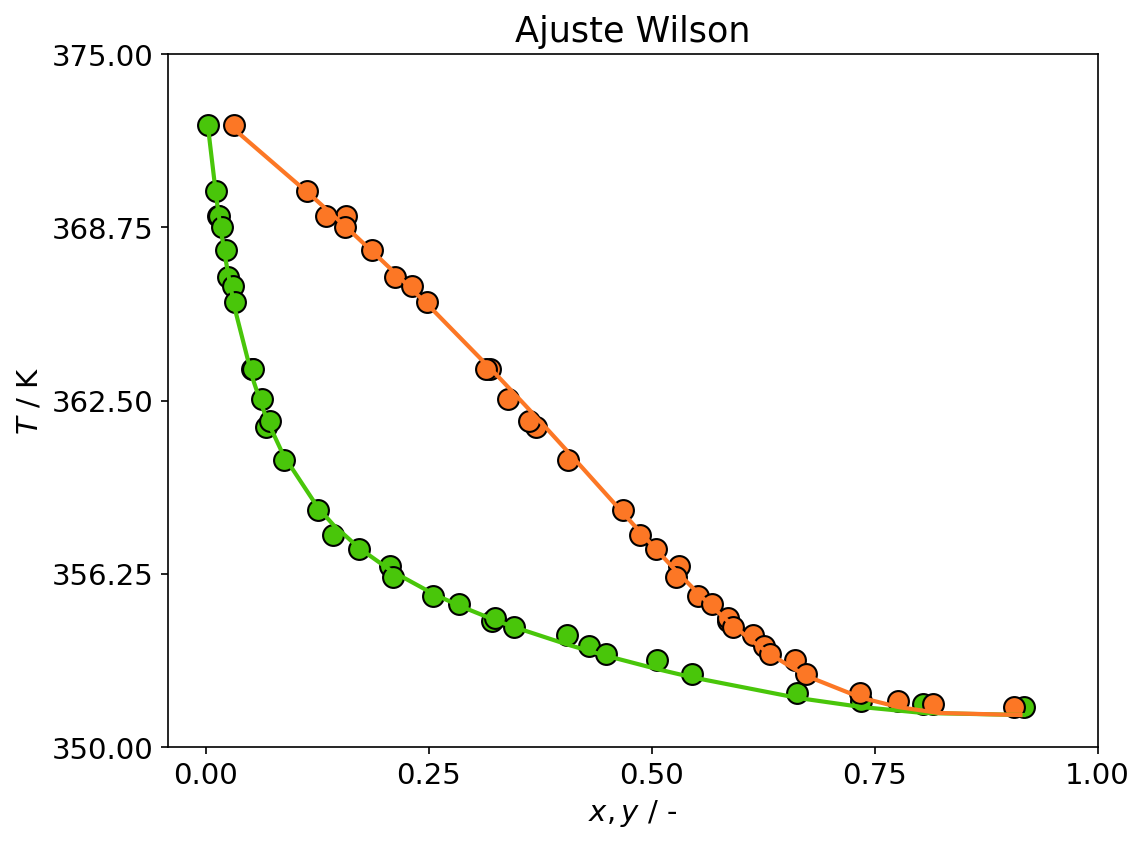

In [10]:
from phasepy import virialgamma
from phasepy.equilibrium import bubbleTy

Ywilson = np.zeros_like(Yexp)
Twilson = np.zeros_like(Pexp)

Aij = np.array([[0., 1.639e+02],
                [4.973e+02, 0.]])
mixwilson.wilson(Aij)

virialwilson = virialgamma(mixwilson, actmodel = 'wilson')

n = len(Pexp)

for i in range(n):
    Ywilson[:,i],Twilson[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialwilson)

font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (8, 6), dpi = 150)
ax.scatter(Xexp[0], Texp, color = '#49C60A', marker = 'o', edgecolors='black', s=100)
ax.scatter(Yexp[0], Texp, color = '#FC7725', marker = 'o', edgecolors='black', s=100)
ax.plot(Xexp[0], Twilson, color = '#49C60A', linewidth = 2.0)
ax.plot(Ywilson[0], Twilson, color = '#FC7725', linewidth = 2.0)



plt.title('Ajuste Wilson')
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x , y$ / -')
ax.xaxis.set_ticks(np.linspace(0, 1, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(350, 375, 5))

plt.show()


<a id='uniquac'></a>

## Ajuste de los parámetros de interacción de UNIQUAC

En el modelo UNIQUAC los coeficientes de actividad se calculan como la suma de un término combinatorio y residual.

$$\ln \gamma_i = \ln \gamma_i^{comb} + \ln \gamma_i^{res} $$

La contribución residual depende de las energías de interacción $(A_{ij}, A_{ji})$ que pueden ajustarse a los datos experimentales.

A medida que se ajusta una matriz, se utilizan algoritmos de optimización multidimensional, la función ```fit_uniquac``` maneja esta optimización. Si se consideran energías de interacción constantes, la estimación inicial tiene la siguiente forma:

A0 = np.matriz([A12, A21])

Los parámetros dependientes de la temperatura se pueden ajustar configurando la opción Tdep = True en ```fit_uniquac```, cuando se usa esta opción las energías de interacción se calculan como:

$$
A12 = A12_0 + A12_1 T \\
A21 = A21_0 + A21_1T
$$

La estimación inicial pasada a la función de ajuste tiene la siguiente forma:

`A0 = np.array([A12_0, A21_0, A12_1, A21_1])`


**nota1:** es necesario proporcionar la superficie molecular y el volumen (``ri`` y ``qi``) a los componentes para que este método funcione.

**nota2:** puedes suministrar las energías UNIQUAC usando el método ``mix.uniquac``.

In [11]:
from phasepy.fit import fit_uniquac

mixuniquac = mix.copy()

# Inicialización de variables (in K)
A0 = np.array([100., 200])
fit_uniquac(A0, mixuniquac, datavle)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00018883263314377214
        x: [ 2.058e+01  1.202e+02]
      nit: 6
      jac: [ 1.250e-06 -2.938e-07]
 hess_inv: [[ 5.269e+04  5.296e+04]
            [ 5.296e+04  5.323e+04]]
     nfev: 39
     njev: 13

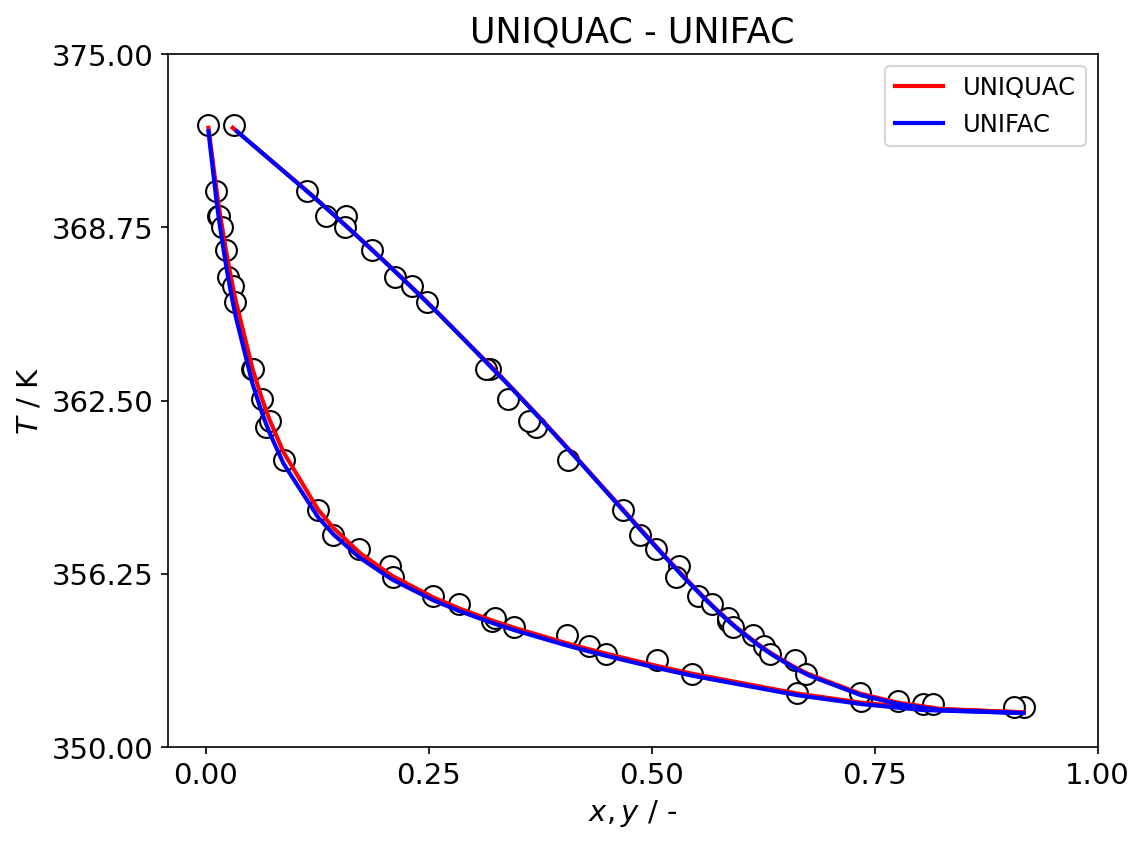

In [12]:
from phasepy import virialgamma
from phasepy.equilibrium import bubbleTy

Yuniquac = np.zeros_like(Yexp)
Tuniquac = np.zeros_like(Pexp)
Yunifac = np.zeros_like(Yexp)
Tunifac = np.zeros_like(Pexp)

mixunifac = mix.copy()
mixunifac.unifac()



A12, A21 = 2.058e+01, 1.202e+02 
Aij0 = np.array([[0., A12], [A21, 0.]])
mix.uniquac(Aij0)

virialuniquac = virialgamma(mixuniquac, actmodel='uniquac')
virialunifac = virialgamma(mix, virialmodel='ideal_gas', actmodel='unifac')


n = len(Pexp)

for i in range(n):
    Yuniquac[:,i],Tuniquac[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialuniquac)
    Yunifac[:,i],Tunifac[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialunifac)

font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (8, 6), dpi = 150)
ax.scatter(Xexp[0], Texp, color = 'white', marker = 'o', edgecolors='black', s=100)
ax.scatter(Yexp[0], Texp, color = 'white', marker = 'o', edgecolors='black', s=100)
ax.plot(Xexp[0], Tuniquac, color = 'red', linewidth = 2.0)
ax.plot(Yuniquac[0], Tuniquac, color = 'red', linewidth = 2.0, label = 'UNIQUAC') 
ax.plot(Xexp[0], Tunifac, color = 'blue', linewidth = 2.0)
ax.plot(Yunifac[0], Tunifac, color = 'blue', linewidth = 2.0, label = 'UNIFAC')


ax.legend(fontsize="small")
plt.title('UNIQUAC - UNIFAC')
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x , y$ / -')
ax.xaxis.set_ticks(np.linspace(0, 1, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(350, 375, 5))

plt.show()